# Initial setup
- Library imports
- Utility functions
- Formatting JSON input

In [49]:
import pandas as pd
import numpy as np
import json
import os
import wget
import cv2
import matplotlib.pyplot as plt

from PIL import Image
import requests
from io import BytesIO

In [50]:
with open(f"items/items.json", "r") as fp:
    item_dict = json.load(fp)
    ITEMS = {i: item_dict[i]["name"] for i in item_dict.keys()}
    ITEM_ICONS = {i: item_dict[i]["icon"] for i in item_dict.keys()}

with open(f"champions.json", "r", encoding="utf-8") as fp:
    CHAMP_DICT = json.load(fp)
    CHAMP_NAME_TO_ID = {c: CHAMP_DICT[c]["id"] for c in CHAMP_DICT.keys()}
    CHAMP_ID_TO_NAME = {CHAMP_DICT[c]["id"]: c for c in CHAMP_DICT.keys()}
    CHAMPION_ICONS = {c: CHAMP_DICT[c]["icon"] for c in CHAMP_DICT.keys()}

def get_item_name(item_id: int):
    return ITEMS.get(str(int(item_id)), "")

def get_item_icon(item_id: int):
    if not item_id:
        return None
    url = ITEM_ICONS.get(str(int(item_id)))
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        return img
    except:
        return Image.new("RGB", (64, 64))

def get_champion_id(champion_name: str):
    if champion_name is None:
        return None
    return CHAMP_NAME_TO_ID.get(champion_name, "")

def get_champion_name(champion_id: int):
    return CHAMP_ID_TO_NAME.get(champion_id)

def get_champion_icon(champion_name: int):
    if not champion_name:
        return None
    url = CHAMPION_ICONS.get(champion_name)
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        return img
    except:
        return Image.new("RGB", (64, 64))

In [51]:
feature_dir = os.path.join("features", "postgame")
filenames = os.listdir(feature_dir)

df_list = []
for fn in filenames:
    sub_df = pd.read_json(os.path.join(feature_dir, fn))
    df_list.append(sub_df)

df = pd.concat(df_list)

print(f"Found {len(df)} matches")

Found 21432 matches


In [52]:
df_expanded = pd.concat([
    df[col].apply(pd.Series).add_prefix(f'{col}_')
    for col in df.columns
], axis=1)

for i in range(10):
    items_col = f"{i}_items"
    items_expanded = df_expanded[items_col].apply(pd.Series)
    items_expanded.columns = [f"{items_col}_{j}" for j in range(items_expanded.shape[1])]
    df_expanded = pd.concat([df_expanded, items_expanded], axis=1)
    df_expanded.drop(f"{i}_items", axis=1, inplace=True)

In [53]:
LANES = ["TOP", "JUNGLE", "MIDDLE", "BOTTOM", "UTILITY"]
print(f"Total matches: {len(df_expanded)}")
df_same_lane = df_expanded[
    (df_expanded["0_lane"] == "TOP")     & (df_expanded["1_lane"] == "TOP") &
    (df_expanded["2_lane"] == "JUNGLE")  & (df_expanded["3_lane"] == "JUNGLE") &
    (df_expanded["4_lane"] == "MIDDLE")  & (df_expanded["5_lane"] == "MIDDLE") &
    (df_expanded["6_lane"] == "BOTTOM")  & (df_expanded["7_lane"] == "BOTTOM") & 
    (df_expanded["8_lane"] == "UTILITY") & (df_expanded["9_lane"] == "UTILITY")
]
print(f"Number of matches with correct lane setup: {len(df_same_lane)}")
df_same_lane.to_csv("features/features_expanded.csv", index=False)

Total matches: 21432
Number of matches with correct lane setup: 20747


In [54]:
# Load champion IDs
with open(f"champions.json", "r", encoding="utf-8") as f:
    json_data = json.load(f)
    info = {json_data[champion]["id"]: champion for champion in json_data.keys()}

# Load Item IDs (Only legendary items)
with open(f"items/items.json", "r", encoding="utf-8") as f:
    json_data = json.load(f)
    item_ids = [json_data[str_id]["id"] for str_id in json_data.keys() if json_data[str_id]["tier"] in [3, 4]]
    item_ids = set(item_ids)

In [55]:
OHE_PLAYER_COLS = [f"player_{c}" for c in CHAMP_NAME_TO_ID.keys()]
OHE_ALLY_COLS = [f"ally_{c}" for c in CHAMP_NAME_TO_ID.keys()]
OHE_ENEMY_COLS = [f"enemy_{c}" for c in CHAMP_NAME_TO_ID.keys()]

# Creating examples
Creating 10 examples out of each match.

In [56]:
# Takes some time to process
def get_team_champions_and_gold(row):
    info = {
        "champions": {
            team: []
            for team in [100, 200]
        },
        "gold": {
            team: 0
            for team in [100, 200]
        },
    }
    for id in range(10):
        info["champions"][row[f"{id}_teamId"]].append(get_champion_name(row[f"{id}_championId"]))
        info["gold"][row[f"{id}_teamId"]] += row[f"{id}_goldEarned"]
    return info["champions"], info["gold"]

def build_new_row(row, cols, playerId, allies, enemies, gold):
    new_row = {}
    player_champion = get_champion_name(row[f"{playerId}_championId"])

    # Player info
    for c in cols:
        new_row[c] = row[f"{playerId}_{c}"]

    # OHE for lane
    new_row[row[f"{playerId}_lane"]] = 1

    new_row[f"player_{player_champion}"] = 1

    # OHE for allies and enemies
    for champ in allies:
        if champ != player_champion:
            new_row[f"ally_{champ}"] = 1
    for champ in enemies:
        new_row[f"enemy_{champ}"] = 1

    new_row["teamGold"] = gold

    return new_row

def expand_match(row):
    team_champions, team_gold = get_team_champions_and_gold(row)
    cols = ["championId", "kills", "deaths", "assists", "goldEarned"] + [f"items_{i}" for i in range(6)]
    new_rows = []

    for playerId in range(10):
        team = row[f"{playerId}_teamId"]
        allies = team_champions[team]
        gold = team_gold[team]
        enemies = team_champions[100 if team == 200 else 200]

        row_data = build_new_row(row, cols, playerId, allies, enemies, gold)
        new_rows.append(row_data)

    return pd.DataFrame(new_rows)

expanded_list = df_same_lane.apply(expand_match, axis=1).tolist()
input_df = pd.concat(expanded_list, ignore_index=True, axis=0).fillna(0)

In [57]:
new_cols = pd.DataFrame({
    "KDA": (input_df["kills"] + input_df["assists"]) / input_df["deaths"],
    "relativeGold": input_df["goldEarned"] / input_df["teamGold"]
})

input_df = pd.concat([input_df, new_cols], axis=1)

## Filtering for high-performance matches

In [58]:
# Amount of games with good performance
for lane in LANES:
    total_matches = len(input_df[(input_df[lane] == 1)])
    print(f"Lane: {lane} -- total matches: {total_matches}")
    lane_df = pd.DataFrame(dtype=str)
    for kda in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]:
        for relativeGold in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]:
            ratio = len(
                input_df[(input_df[lane] == 1) & \
                         (input_df["KDA"] >= kda) & \
                         (input_df["relativeGold"] >= relativeGold)
                        ]
            ) / total_matches
            lane_df.loc[f"KDA>={kda}", f"gold>={relativeGold}"] = f"{ratio*100:.2f}%"
    display(lane_df)

Lane: TOP -- total matches: 41494


gold>=0.05 gold>=0.1 gold>=0.15 gold>=0.2 gold>=0.25 gold>=0.3  \
KDA>=0.5     89.84%    89.83%     88.59%    51.91%      7.62%     0.31%   
KDA>=1.0     75.58%    75.57%     74.78%    46.04%      7.36%     0.31%   
KDA>=1.5     58.60%    58.60%     58.14%    37.61%      6.51%     0.29%   
KDA>=2.0     46.94%    46.93%     46.60%    31.31%      5.70%     0.27%   
KDA>=2.5     36.02%    36.02%     35.81%    24.73%      4.77%     0.23%   
KDA>=3.0     29.54%    29.53%     29.40%    20.73%      4.11%     0.21%   

         gold>=0.35  
KDA>=0.5      0.00%  
KDA>=1.0      0.00%  
KDA>=1.5      0.00%  
KDA>=2.0      0.00%  
KDA>=2.5      0.00%  
KDA>=3.0      0.00%

Lane: JUNGLE -- total matches: 41494


gold>=0.05 gold>=0.1 gold>=0.15 gold>=0.2 gold>=0.25 gold>=0.3  \
KDA>=0.5     95.85%    95.85%     95.58%    64.79%      9.69%     0.38%   
KDA>=1.0     88.39%    88.39%     88.21%    61.35%      9.51%     0.38%   
KDA>=1.5     75.35%    75.35%     75.25%    53.90%      8.94%     0.37%   
KDA>=2.0     63.79%    63.79%     63.71%    46.70%      8.10%     0.34%   
KDA>=2.5     52.65%    52.65%     52.60%    39.30%      7.19%     0.32%   
KDA>=3.0     45.12%    45.12%     45.08%    34.25%      6.39%     0.28%   

         gold>=0.35  
KDA>=0.5      0.01%  
KDA>=1.0      0.01%  
KDA>=1.5      0.01%  
KDA>=2.0      0.01%  
KDA>=2.5      0.01%  
KDA>=3.0      0.01%

Lane: MIDDLE -- total matches: 41494


gold>=0.05 gold>=0.1 gold>=0.15 gold>=0.2 gold>=0.25 gold>=0.3  \
KDA>=0.5     93.62%    93.61%     93.02%    59.50%      8.82%     0.43%   
KDA>=1.0     83.77%    83.77%     83.31%    55.04%      8.59%     0.43%   
KDA>=1.5     68.92%    68.92%     68.65%    46.86%      7.81%     0.41%   
KDA>=2.0     57.51%    57.51%     57.31%    40.18%      6.91%     0.39%   
KDA>=2.5     45.73%    45.72%     45.60%    32.82%      5.88%     0.35%   
KDA>=3.0     38.14%    38.14%     38.04%    27.88%      5.13%     0.31%   

         gold>=0.35  
KDA>=0.5      0.01%  
KDA>=1.0      0.01%  
KDA>=1.5      0.01%  
KDA>=2.0      0.01%  
KDA>=2.5      0.01%  
KDA>=3.0      0.01%

Lane: BOTTOM -- total matches: 41494


gold>=0.05 gold>=0.1 gold>=0.15 gold>=0.2 gold>=0.25 gold>=0.3  \
KDA>=0.5     94.47%    94.47%     94.15%    71.50%     15.13%     0.90%   
KDA>=1.0     84.93%    84.93%     84.75%    66.55%     14.87%     0.90%   
KDA>=1.5     70.48%    70.48%     70.39%    57.25%     13.91%     0.88%   
KDA>=2.0     59.07%    59.07%     59.02%    49.07%     12.60%     0.85%   
KDA>=2.5     47.26%    47.26%     47.23%    40.26%     11.01%     0.79%   
KDA>=3.0     39.35%    39.35%     39.32%    33.99%      9.73%     0.72%   

         gold>=0.35  
KDA>=0.5      0.02%  
KDA>=1.0      0.02%  
KDA>=1.5      0.02%  
KDA>=2.0      0.02%  
KDA>=2.5      0.02%  
KDA>=3.0      0.02%

Lane: UTILITY -- total matches: 41494


gold>=0.05 gold>=0.1 gold>=0.15 gold>=0.2 gold>=0.25 gold>=0.3  \
KDA>=0.5     96.10%    96.10%     42.69%     2.02%      0.07%     0.00%   
KDA>=1.0     89.20%    89.20%     39.89%     1.92%      0.06%     0.00%   
KDA>=1.5     76.57%    76.57%     34.36%     1.65%      0.05%     0.00%   
KDA>=2.0     65.40%    65.40%     29.59%     1.38%      0.04%     0.00%   
KDA>=2.5     53.98%    53.98%     24.71%     1.12%      0.04%     0.00%   
KDA>=3.0     46.11%    46.11%     21.44%     0.92%      0.04%     0.00%   

         gold>=0.35  
KDA>=0.5      0.00%  
KDA>=1.0      0.00%  
KDA>=1.5      0.00%  
KDA>=2.0      0.00%  
KDA>=2.5      0.00%  
KDA>=3.0      0.00%

In [59]:
# keep the top ~70% of the matches
HIGH_PERFORMANCE_INDICATORS = {
    "TOP": {
        "KDA": 1.0,
        "relativeGold": 0.15
    },
    "JUNGLE": {
        "KDA": 1.5,
        "relativeGold": 0.15
    },
    "MIDDLE": {
        "KDA": 1.0,
        "relativeGold": 0.15
    },
    "BOTTOM": {
        "KDA": 1.5,
        "relativeGold": 0.15
    },
    "UTILITY": {
        "KDA": 1.5,
        "relativeGold": 0.1
    },
}

def keep_high_performance(row):
    lane = "".join([lane for lane in LANES if row[lane] == 1])
    for indicator, min_val in HIGH_PERFORMANCE_INDICATORS[lane].items():
        if row[indicator] < min_val:
            return False
    return True

high_df = input_df[input_df.apply(keep_high_performance, axis=1)]
print(f"Final number of examples: {len(high_df)}")

Final number of examples: 161152


In [61]:
high_df.head()

championId  kills  deaths  assists  goldEarned  items_0  items_1  items_2  \
1          84     17       4        4       12871   3020.0   4645.0   4646.0   
3         950      2       4       15       10327   6692.0   6698.0   3158.0   
4         112      2       8        6        7440   3040.0   3100.0      0.0   
5          55     13       2        5       11525   3020.0   3100.0   4645.0   
6         202      4       6        5        8019   3094.0   6676.0   3009.0   

   items_3  items_4  ...  enemy_Neeko  player_Neeko  ally_Nilah  enemy_Nilah  \
1      0.0      0.0  ...          0.0           0.0         0.0          0.0   
3      0.0      0.0  ...          0.0           0.0         0.0          0.0   
4      0.0      0.0  ...          0.0           0.0         0.0          0.0   
5      0.0      0.0  ...          0.0           0.0         0.0          0.0   
6      0.0      0.0  ...          0.0           0.0         0.0          0.0   

   player_Nilah  enemy_Shyvana  ally_Shyvana  player_Shyvana   KDA  \
1           0.0            0.0           0.0             0.0  5.25   
3           0.0            0.0           0.0             0.0  4.25   
4           0.0            0.0           0.0             0.0  1.00   
5           0.0            0.0           0.0             0.0  9.00   
6           0.0            0.0           0.0             0.0  1.50   

   relativeGold  
1      0.258974  
3      0.207787  
4      0.192731  
5      0.231891  
6      0.207730  

[5 rows x 529 columns]

## Defining input and output vectors

In [70]:
input_cols = [
    col for col in high_df.columns
    if any(
           [col.startswith(prefix) for prefix in ["player", "ally", "enemy"]]
          ) or col in LANES

]
output_cols = [
    col for col in high_df.columns
    if col.startswith("items")
]

championIds = high_df["championId"]
X = high_df[input_cols]
y = high_df[output_cols]

print(f"Total examples: {len(X)}")

Total examples: 161152


# Random Forest

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, jaccard_score, f1_score, make_scorer, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, KFold

from scipy.stats import randint, uniform  # for distributions

In [72]:
# `y_class` is shape (n_samples, 6) with 0s as padding

# Convert to sets of items (removing zeros)
y_sets = y.apply(lambda row: [int(i) for i in row if i != 0 and not pd.isna(i)], axis=1)

# Binarize
mlb = MultiLabelBinarizer()
y_bin = mlb.fit_transform(y_sets)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.5, random_state=42, stratify=championIds
)

In [73]:
from sklearn.metrics import make_scorer, f1_score
import numpy as np

def make_top_k_f1_scorer(mlb, k=6):
    def top_k_f1_score(estimator, X, y_true):
        try:
            y_proba = estimator.predict_proba(X)

            # Ensure we have probabilities for all classes in mlb.classes_
            if len(y_proba) != len(mlb.classes_):
                # Create full matrix with zeros, then fill in existing probabilities
                proba_matrix = np.zeros((X.shape[0], len(mlb.classes_)))
                trained_classes = estimator.classes_
                for i, cls in enumerate(trained_classes):
                    class_index = np.where(mlb.classes_ == cls)[0][0]
                    proba_matrix[:, class_index] = y_proba[i][:, 1]
            else:
                proba_matrix = np.array([p[:, 1] for p in y_proba]).T

            top_k_preds = np.argsort(proba_matrix, axis=1)[:, -k:][:, ::-1]
            pred_sets = [[mlb.classes_[idx] for idx in row] for row in top_k_preds]
            pred_bin = mlb.transform(pred_sets)

            return f1_score(y_true, pred_bin, average='samples', zero_division=0)

        except Exception as e:
            # Return a very low score if something fails, to avoid crashing search
            return 0.0

    return make_scorer(top_k_f1_score, needs_proba=False)

In [74]:
base_rf = RandomForestClassifier(random_state=42, n_jobs=1)
multi_rf = MultiOutputClassifier(base_rf, n_jobs=1)

In [75]:
param_dist = {
    'estimator__n_estimators': randint(10, 30),
    'estimator__max_depth': randint(5, 15),
    'estimator__min_samples_leaf': randint(5, 20),
    'estimator__ccp_alpha': uniform(0.0, 0.01)
}

kf = KFold(n_splits=3, shuffle=True, random_state=42)
custom_scorer = make_top_k_f1_scorer(mlb, k=6)

random_search = RandomizedSearchCV(
    estimator=multi_rf,
    param_distributions=param_dist,
    n_iter=10,  # number of sampled combinations
    scoring=custom_scorer,
    cv=kf,
    verbose=3,
    n_jobs=4,
    refit=True,
    random_state=42
)

In [77]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\User\Desktop\programacao\mc906\venv\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=MultiOutputClassifier(estimator=RandomForestClassifier(n_jobs=1,
                                                                                    random_state=42),
                                                   n_jobs=1),
                   n_jobs=4,
                   param_distributions={'estimator__ccp_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001AC2E3BB650>,
                                        'estimator__max_depth': <scipy.stats._distn_i...ect at 0x000001AC70C09160>,
                                        'estimator__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001AC4F363020>,
                                        'estimator__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001AC5D6EA7E0>},
                   random_state=42,
                   scoring=make_scorer(top_k_f1_score, response_method='predict', needs_proba=False),
                   verbose=3)

In [78]:
best_model = random_search.best_estimator_

# Optional: Evaluate on your separate test set if you have one
y_proba = best_model.predict_proba(X_test)
proba_matrix = np.array([p[:, 1] for p in y_proba]).T
top_6_preds = np.argsort(proba_matrix, axis=1)[:, -6:][:, ::-1]
pred_sets = [[mlb.classes_[idx] for idx in row] for row in top_6_preds]
pred_bin = mlb.transform(pred_sets)

# pred_bin: binary matrix (n_samples, n_labels), 1s in top-6 slots
# y_test: binary matrix of ground truth

recall_at_6 = recall_score(y_test, pred_bin, average='samples', zero_division=0)
precision_at_6 = precision_score(y_test, pred_bin, average='samples', zero_division=0)

print(f"Recall@6: {recall_at_6:.4f}")
print(f"Precision@6: {precision_at_6:.4f}")

Recall@6: 0.3658
Precision@6: 0.2112


# MLP

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim

In [81]:
from sklearn.model_selection import train_test_split
import torch
import numpy as np

# Split X and y while keeping y as DataFrame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=championIds)

# Multi-hot encode y
unique_item_ids = sorted(set(np.unique(y.values.flatten())) - {0})  # Removing zero (assumed as 'no item' marker)
item_id_to_idx = {item_id: idx for idx, item_id in enumerate(unique_item_ids)}
num_items = len(unique_item_ids)
print(f"Total items: {num_items}")

def multi_hot_encode(row):
    vec = np.zeros(num_items, dtype=np.float32)
    for item_id in row:
        if item_id != 0:
            vec[item_id_to_idx[item_id]] = 1.0
    return vec

# Convert y_train
y_train_multi_hot = np.vstack(y_train.apply(multi_hot_encode, axis=1).to_numpy())
y_train_tensor = torch.tensor(y_train_multi_hot, dtype=torch.float32)

# Convert y_test
y_test_multi_hot = np.vstack(y_test.apply(multi_hot_encode, axis=1).to_numpy())
y_test_tensor = torch.tensor(y_test_multi_hot, dtype=torch.float32)

# Convert X
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

Total items: 121


In [82]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()  # Because it's multi-label (not softmax)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

In [83]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

num_epochs = 40
batch_size = 64
k_folds = 5

criterion = nn.BCELoss(reduction='mean')
kfold = KFold(n_splits=k_folds, shuffle=True)

# To store loss history for all folds
all_train_losses = []
all_val_losses = []

best_val_loss = float('inf')
best_model_state = None

for fold, (train_ids, val_ids) in enumerate(kfold.split(X_test_tensor)):
    print(f'Fold {fold+1}')

    # Split data
    train_X, train_y = X_test_tensor[train_ids], y_test_tensor[train_ids]
    val_X, val_y = X_test_tensor[val_ids], y_test_tensor[val_ids]

    model = SimpleMLP(input_dim=X.shape[1], output_dim=y_test_tensor.shape[1])
    optimizer = torch.optim.Adam(model.parameters())

    # Store losses per epoch for this fold
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        permutation = torch.randperm(train_X.size(0))
        total_loss = 0

        for i in range(0, train_X.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_X, batch_y = train_X[indices], train_y[indices]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch_X.size(0)  # sum of loss per sample

        model.eval()
        with torch.no_grad():
            val_outputs = model(val_X)
            val_loss = criterion(val_outputs, val_y).item()

        avg_train_loss = total_loss / train_X.size(0)
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)

        print(f'Fold {fold+1}, Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    # Save fold losses
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

Fold 1
Fold 1, Epoch 1, Train Loss: 0.1509, Val Loss: 0.1199
Fold 1, Epoch 2, Train Loss: 0.0980, Val Loss: 0.0847
Fold 1, Epoch 3, Train Loss: 0.0789, Val Loss: 0.0759
Fold 1, Epoch 4, Train Loss: 0.0726, Val Loss: 0.0719
Fold 1, Epoch 5, Train Loss: 0.0695, Val Loss: 0.0704
Fold 1, Epoch 6, Train Loss: 0.0675, Val Loss: 0.0693
Fold 1, Epoch 7, Train Loss: 0.0660, Val Loss: 0.0687
Fold 1, Epoch 8, Train Loss: 0.0647, Val Loss: 0.0679
Fold 1, Epoch 9, Train Loss: 0.0634, Val Loss: 0.0680
Fold 1, Epoch 10, Train Loss: 0.0622, Val Loss: 0.0678
Fold 1, Epoch 11, Train Loss: 0.0610, Val Loss: 0.0682
Fold 1, Epoch 12, Train Loss: 0.0599, Val Loss: 0.0681
Fold 1, Epoch 13, Train Loss: 0.0586, Val Loss: 0.0685
Fold 1, Epoch 14, Train Loss: 0.0573, Val Loss: 0.0687
Fold 1, Epoch 15, Train Loss: 0.0561, Val Loss: 0.0699
Fold 1, Epoch 16, Train Loss: 0.0548, Val Loss: 0.0705
Fold 1, Epoch 17, Train Loss: 0.0535, Val Loss: 0.0718
Fold 1, Epoch 18, Train Loss: 0.0522, Val Loss: 0.0726
Fold 1, Epoc

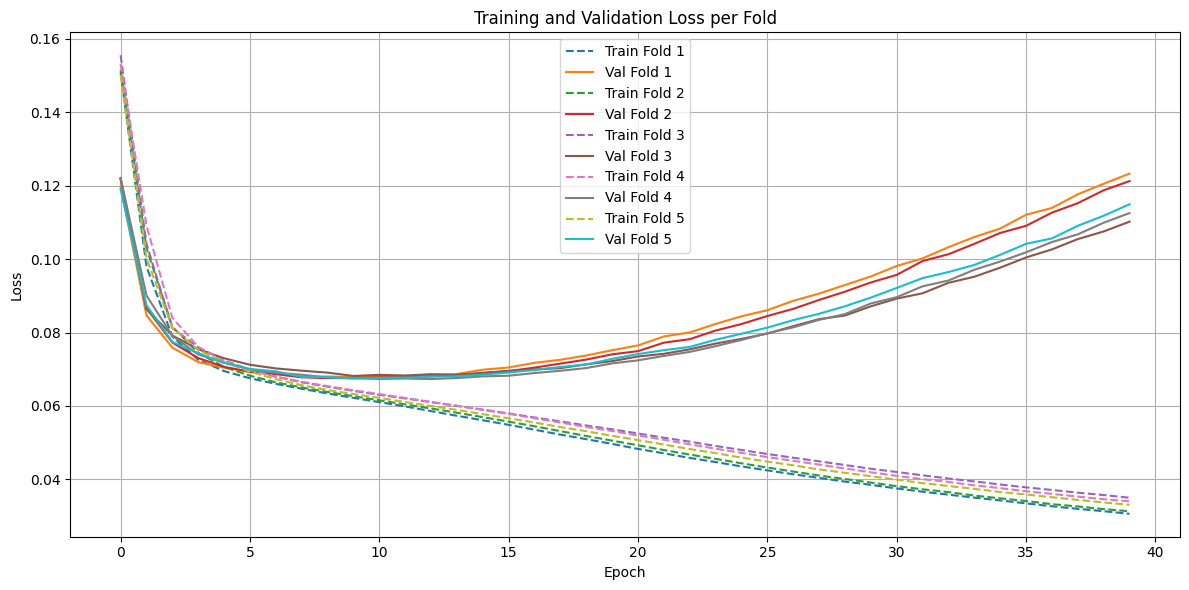

In [84]:
# Plotting after training
plt.figure(figsize=(12, 6))
for fold in range(k_folds):
    plt.plot(all_train_losses[fold], label=f'Train Fold {fold+1}', linestyle='--')
    plt.plot(all_val_losses[fold], label=f'Val Fold {fold+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Fold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [85]:
# Load best model
best_model = SimpleMLP(input_dim=X.shape[1], output_dim=y_test_tensor.shape[1])
best_model.load_state_dict(best_model_state)

<All keys matched successfully>

In [86]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    test_loss = criterion(outputs, y_test_tensor)
    print(f"Test Loss: {test_loss.item()}")

    # Get top 6 predictions for each sample
    _, top6_indices = torch.topk(outputs, k=6, dim=1)

    # Total number of samples
    total_samples = y_test_tensor.shape[0]
    all_slots_correct_samples = 0
    single_slot_correct_samples = 0

    for i in range(total_samples):
        # Indices of true labels (where y == 1)
        true_indices = (y_test_tensor[i] == 1).nonzero(as_tuple=True)[0]

        # Skip if there are no true labels (optional: depends on your definition of accuracy)
        if true_indices.numel() == 0:
            continue

        # Indices predicted as top-6
        predicted_top6 = top6_indices[i]

        single_slot_correct = 0
        # Check if all true labels are in the top-6
        if set(true_indices.tolist()).issubset(set(predicted_top6.tolist())):
            all_slots_correct_samples += 1
            single_slot_correct_samples += 1
        else:
            for idx in true_indices.tolist():
                if idx in set(predicted_top6.tolist()):
                    single_slot_correct += 1
            single_slot_correct_samples += single_slot_correct / len(true_indices.tolist())

    # Top-6 accuracy based only on rows that had at least one positive label
    all_slots_accuracy = all_slots_correct_samples / total_samples
    single_slot_accuracy = single_slot_correct_samples / total_samples
    print(f"All slots - accuracy: {all_slots_accuracy:.4f}")
    print(f"Single slot - accuracy: {single_slot_accuracy:.4f}")

Test Loss: 0.04745308682322502
All slots - accuracy: 0.5909
Single slot - accuracy: 0.8304


In [87]:
import torch
from torchmetrics.classification import MultilabelRecall, MultilabelPrecision

# Define metrics
num_labels = y_test_tensor.shape[1]
recall_metric = MultilabelRecall(num_labels=num_labels, average='macro')
precision_metric = MultilabelPrecision(num_labels=num_labels, average='macro')

# Generate predictions from top-6
top_k = 6
outputs = model(X_test_tensor)

# Create binary predictions: 1 if in top-6, else 0
topk_indices = torch.topk(outputs, k=top_k, dim=1).indices
preds_topk = torch.zeros_like(outputs)
preds_topk.scatter_(1, topk_indices, 1)

# Compute metrics
recall_at_6 = recall_metric(preds_topk, y_test_tensor)
precision_at_6 = precision_metric(preds_topk, y_test_tensor)

print(f"Recall@6: {recall_at_6.item():.4f}")
print(f"Precision@6: {precision_at_6.item():.4f}")


Recall@6: 0.7281
Precision@6: 0.4618


In [88]:
# X_custom = pd.DataFrame(columns=X.columns)
# X_custom = pd.concat([pd.DataFrame([[0] * len(X_custom.columns)] * 256, columns=X_custom.columns), X_custom], ignore_index=True)

X_custom = X_test

# Agora, converter todas as colunas para float32
X_custom_tensor = torch.tensor(X_custom.values.astype(np.float32))

all_topk = []
model.eval()
with torch.no_grad():
    for i in range(0, len(X_custom_tensor) - 340, 340):
        outputs = model(X_custom_tensor[i:i+340, :])
        topk_values, topk_indices = torch.topk(outputs, k=6, dim=1)
        all_topk.append(topk_indices)

all_recommendations = []
for i, topk_indices in enumerate(all_topk):
    for j in range(topk_indices.shape[0]):
        predicted_idx = []
        for idx in topk_indices[j]:
            predicted_idx.append(idx)
        predicted_items = []
        for id, idx in item_id_to_idx.items():
            if idx in predicted_idx:
                predicted_items.append(id)
        all_recommendations.append(predicted_items)

In [89]:
def show_build(item_ids):
    fig, axs = plt.subplots(1, len(item_ids), figsize=(2 * len(item_ids), 2))
    if len(item_ids) == 1:
        axs = [axs]  # ensure iterable
    for i, id in enumerate(item_ids):
        icon = get_item_icon(id)
        if icon:
            axs[i].imshow(icon)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

def compare_builds(
        df: pd.DataFrame,
        all_recommendations: list,
        build_df,
        original_index,
        idx: int):
    orig_idx = original_index[idx]

    allies = []
    enemies = []
    analysed_champion = ""
    for col in df.columns:
        if df.loc[orig_idx, col] == 0:
            continue
        if col.startswith("player"):
            analysed_champion = col.split("_")[1]
            print(f"Champion: {analysed_champion}")
        elif col.startswith("ally"):
            allies.append(col.split("_")[1])
        elif col.startswith("enemy"):
            enemies.append(col.split("_")[1])
        elif col in LANES:
            print(f"Lane: {col.lower().capitalize()}")

    reccomended_items = sorted(all_recommendations[idx], key=lambda x: x if x > 0 else 9999)
    print(f"Allies: {', '.join(champ for champ in allies)}")
    print(f"Enemies: {', '.join(champ for champ in enemies)}")
    print(f"Recommendations: {', '.join(
        [f"{get_item_name(item):<30}" for item in reccomended_items]
    )}")

    original_build = []
    for i in range(6):
        item_col = f"items_{i}"
        item_id = build_df.loc[orig_idx, item_col]
        if item_id.is_integer():
            original_build.append(int(item_id))
    original_build.sort(key=lambda x: x if x > 0 else 9999)
    print(f"Original IDX: {orig_idx}")
    print(f"Original build : {', '.join(
        [f'{get_item_name(item):<30}' for item in original_build]
    )}")

    print("Recommended build")
    show_build(sorted(reccomended_items))

    print("Original build")
    show_build(sorted(original_build, key=lambda x: x if x > 0 else 9999))

In [93]:
# selected_champion = X_custom["championId"].value_counts().idxmax()
selected_champion = "Riven"
selected_champion_id = get_champion_id(selected_champion)
print(f"Selected champion: {get_champion_name(selected_champion)} - ID: {selected_champion_id}")

Selected champion: None - ID: 92


In [94]:
df_selected = X_custom.iloc[:len(all_recommendations), :]
df_selected.loc[:, "index"] = range(len(df_selected))
df_selected = df_selected[df_selected[f"player_{selected_champion}"] == 1]

C:\Users\User\AppData\Local\Temp\ipykernel_38372\599549783.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.loc[:, "index"] = range(len(df_selected))


Lane: Top
Champion: Riven
Allies: Kaisa, Lux, Sylas, LeeSin
Enemies: Akali, Nasus, Morgana, Ashe, Warwick
Recommendations: Mercury's Treads              , Blade of the Ruined King      , Maw of Malmortius             , Sundered Sky                  , Eclipse                       , Profane Hydra                 
Original IDX: 145201
Original build : Sundered Sky                  , Eclipse                       ,                               ,                               ,                               ,                               
Recommended build


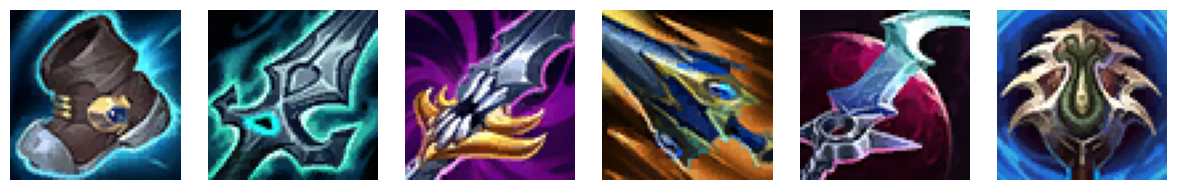

Original build


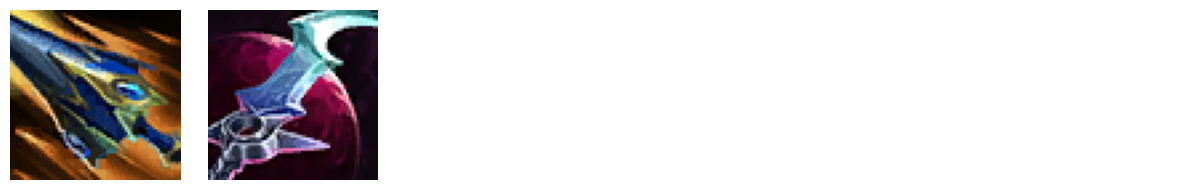

Lane: Top
Champion: Riven
Allies: Katarina, MasterYi, Lux, Vayne
Enemies: Seraphine, Ezreal, Syndra, Camille, Nunu
Recommendations: Black Cleaver                 , Ravenous Hydra                , Mercury's Treads              , Maw of Malmortius             , Sundered Sky                  , Eclipse                       
Original IDX: 75020
Original build : Black Cleaver                 , Mercury's Treads              , Maw of Malmortius             , Sundered Sky                  , Eclipse                       ,                               
Recommended build


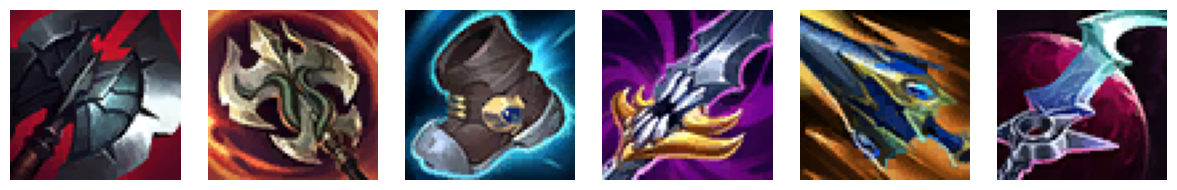

Original build


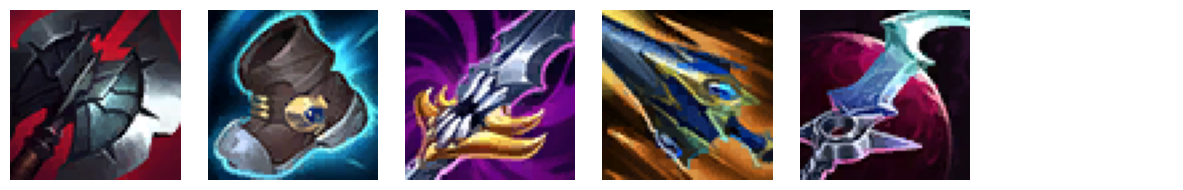

Lane: Top
Champion: Riven
Allies: DrMundo, Khazix, Thresh, Caitlyn
Enemies: Nami, Yasuo, Senna, Chogath, Kayn
Recommendations: Plated Steelcaps              , Ionian Boots of Lucidity      , Death's Dance                 , Sundered Sky                  , Eclipse                       , Serylda's Grudge              
Original IDX: 146110
Original build : Plated Steelcaps              , Sundered Sky                  , Eclipse                       ,                               ,                               ,                               
Recommended build


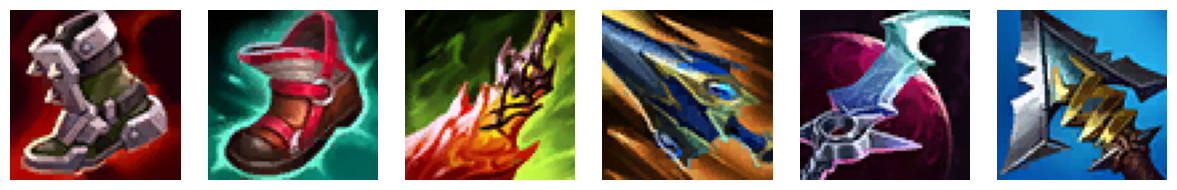

Original build


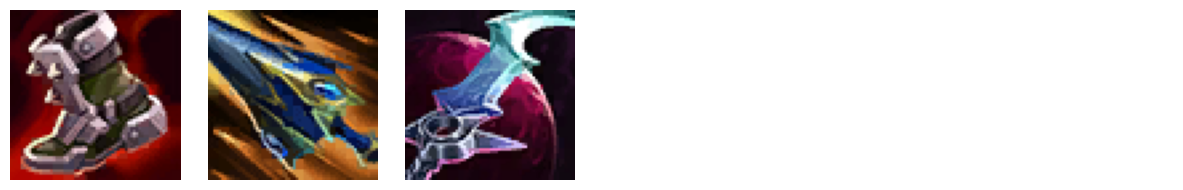

Lane: Top
Champion: Riven
Allies: Xerath, Smolder, MonkeyKing, Alistar
Enemies: Kaisa, Viego, Sylas, Nautilus, KSante
Recommendations: Black Cleaver                 , Ionian Boots of Lucidity      , Crimson Lucidity              , Death's Dance                 , Sundered Sky                  , Eclipse                       
Original IDX: 189840
Original build : Ionian Boots of Lucidity      , Eclipse                       ,                               ,                               ,                               ,                               
Recommended build


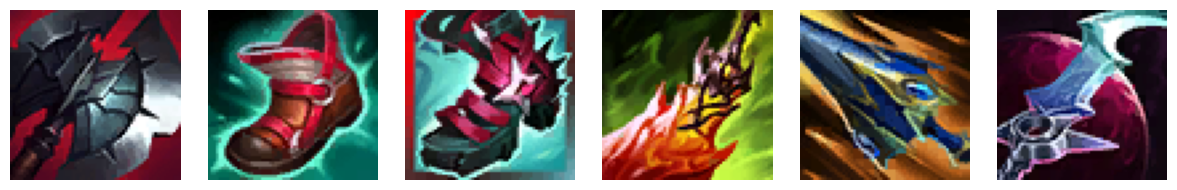

Original build


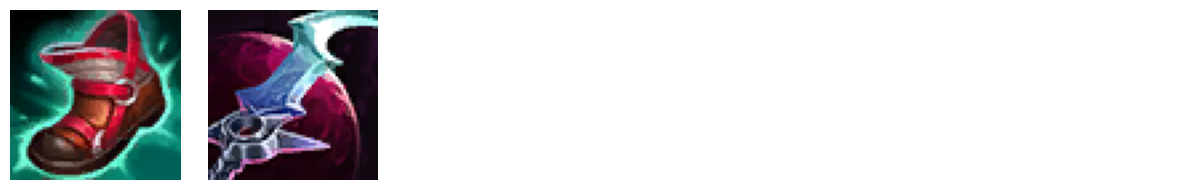

Lane: Top
Champion: Riven
Allies: Jinx, Leona, Ahri, Teemo
Enemies: Kaisa, Swain, Aurora, Akshan, Graves
Recommendations: Plated Steelcaps              , Black Cleaver                 , Ionian Boots of Lucidity      , Death's Dance                 , Sundered Sky                  , Eclipse                       
Original IDX: 201841
Original build : Ionian Boots of Lucidity      , Death's Dance                 , Sundered Sky                  , Eclipse                       ,                               ,                               
Recommended build


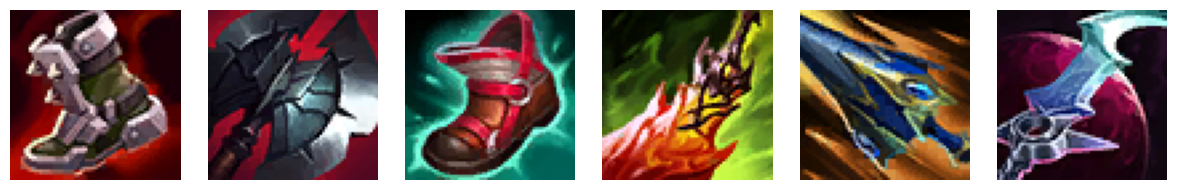

Original build


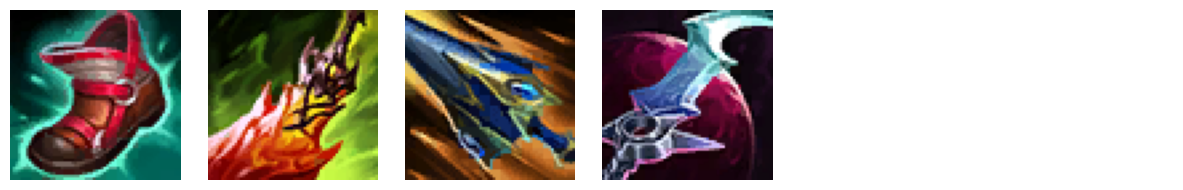

Lane: Top
Champion: Riven
Allies: Jhin, TwistedFate, Shaco, Soraka
Enemies: Aurora, MasterYi, Seraphine, Ambessa, Rakan
Recommendations: Ionian Boots of Lucidity      , Death's Dance                 , Sundered Sky                  , Eclipse                       , Serylda's Grudge              , Serpent's Fang                
Original IDX: 35751
Original build : Randuin's Omen                , Crimson Lucidity              , Death's Dance                 , Sundered Sky                  , Eclipse                       , Serylda's Grudge              
Recommended build


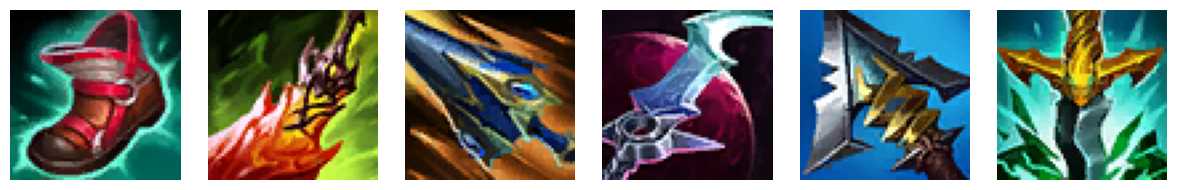

Original build


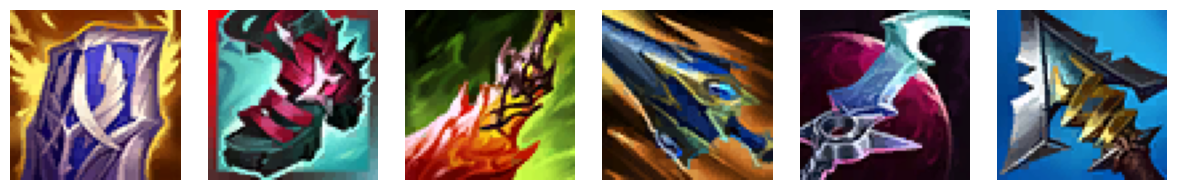

Lane: Top
Champion: Riven
Allies: Akali, Jinx, LeeSin, Fiddlesticks
Enemies: Gwen, Diana, JarvanIV, Kayn, Varus
Recommendations: Maw of Malmortius             , Ionian Boots of Lucidity      , Armored Advance               , Death's Dance                 , Sundered Sky                  , Eclipse                       
Original IDX: 103620
Original build : Crimson Lucidity              , Sundered Sky                  , Eclipse                       ,                               ,                               ,                               
Recommended build


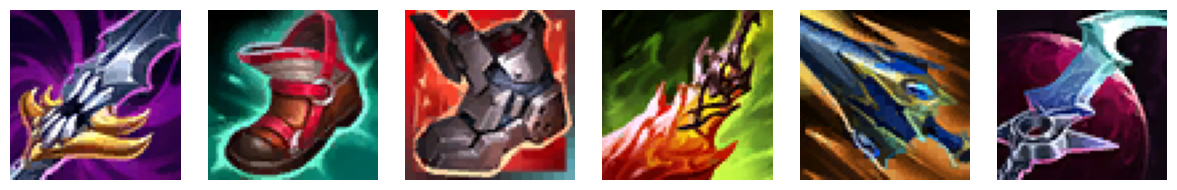

Original build


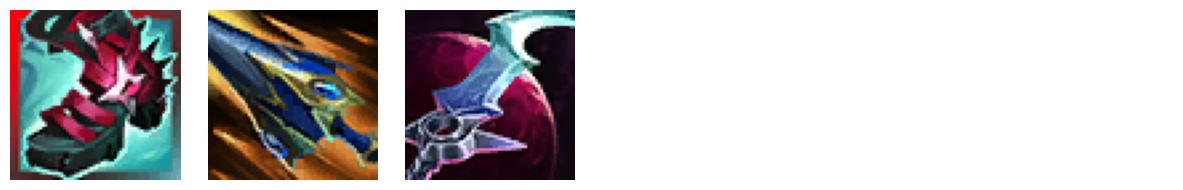

Lane: Top
Champion: Riven
Allies: Karma, Senna, Lux, Shaco
Enemies: Akali, Jhin, Hecarim, Milio, Shyvana
Recommendations: Black Cleaver                 , Maw of Malmortius             , Ionian Boots of Lucidity      , Death's Dance                 , Sundered Sky                  , Eclipse                       
Original IDX: 35560
Original build : Ionian Boots of Lucidity      , Death's Dance                 , Sundered Sky                  , Eclipse                       , Serpent's Fang                ,                               
Recommended build


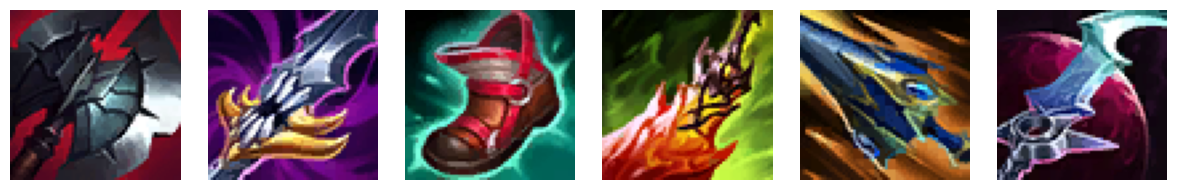

Original build


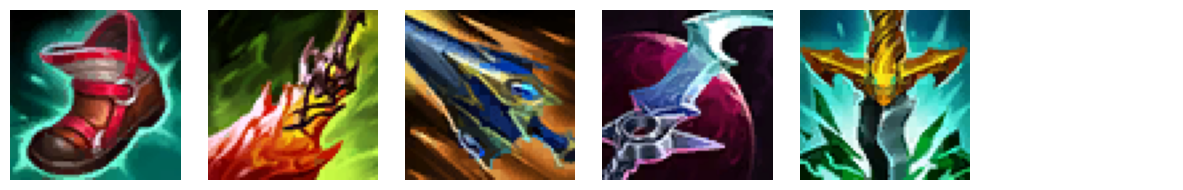

Lane: Top
Champion: Riven
Allies: Vladimir, Nautilus, Fiddlesticks, Kalista
Enemies: Katarina, Draven, Thresh, JarvanIV, Ambessa
Recommendations: Plated Steelcaps              , Ionian Boots of Lucidity      , Death's Dance                 , Sundered Sky                  , Eclipse                       , Serylda's Grudge              
Original IDX: 181310
Original build : Ionian Boots of Lucidity      , Death's Dance                 , Sundered Sky                  , Eclipse                       , Serylda's Grudge              ,                               
Recommended build


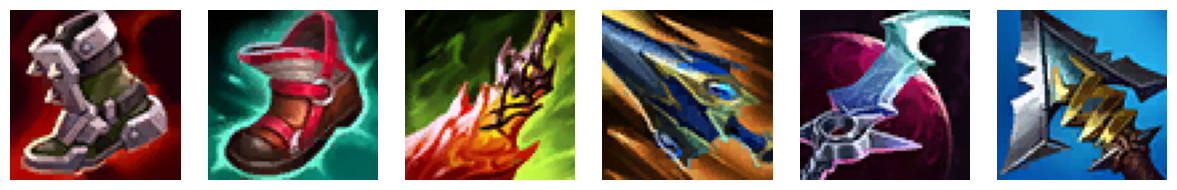

Original build


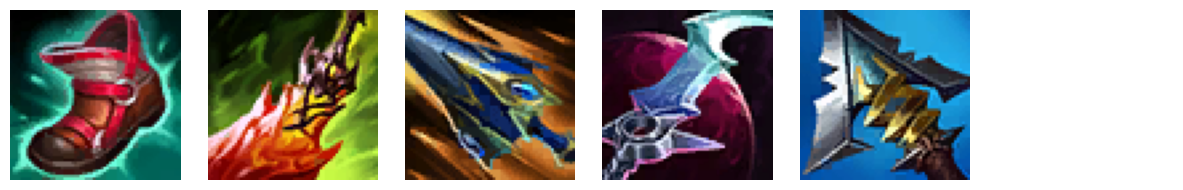

Lane: Top
Champion: Riven
Allies: Kaisa, Akali, Braum, Warwick
Enemies: Lux, Zed, Mordekaiser, Caitlyn, Zac
Recommendations: Sterak's Gage                 , Black Cleaver                 , Ionian Boots of Lucidity      , Death's Dance                 , Sundered Sky                  , Eclipse                       
Original IDX: 103601
Original build : Ionian Boots of Lucidity      , Spear of Shojin               , Death's Dance                 , Sundered Sky                  , Eclipse                       ,                               
Recommended build


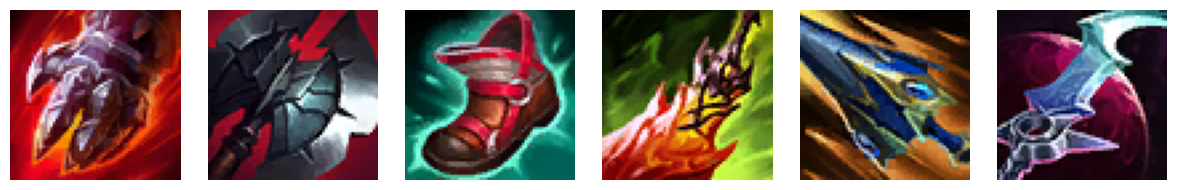

Original build


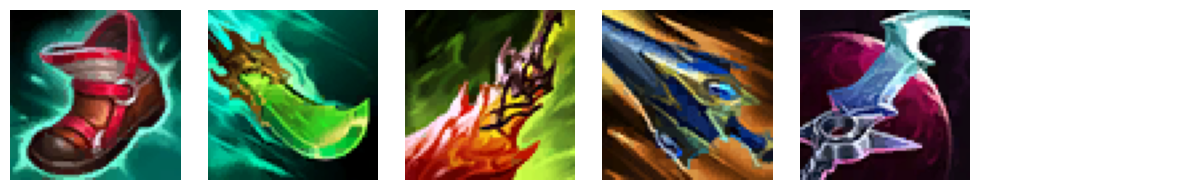

In [95]:
for index, row in list(df_selected.iterrows())[:10]:
    idx = int(row["index"])
    compare_builds(
        X_test,
        all_recommendations,
        y_test,
        pd.Series(
            {
                idx_from_0:
                    X_test.index[idx_from_0]
                for idx_from_0 in range(len(X_custom))
            }
        ),
        idx
    )

In [ ]:
# Save
torch.save(model.state_dict(), "model_weights.pth")

# Load (later)
model = SimpleMLP()
model.load_state_dict(torch.load("model_weights.pth"))
model.eval()  # Set to eval mode if you're evaluating/inference